In [1]:
# Magic line to force reload all modules when this cell is run multiple times
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "/Users/Work/Developer/interpretDL/Pipeline")

In [2]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.offline import plot
import ipywidgets as widgets

# %matplotlib widget
py.offline.init_notebook_mode(connected=True)

In [3]:
import numpy as np
import pandas as pd
import umap

from ClusterPipeline import ClusterPipeline
from helper import split_valid, plot_confusion_matrix, plot_history
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

RANDOM_STATE = 42
np.random.seed(seed=RANDOM_STATE) 

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/Users/Work/anaconda3/envs/condatensor/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



In [4]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.close("History")
    fig, axs = plt.subplots(1, 2, figsize=(16,8),num="History")

    # Plot training & validation accuracy values
    axs[0].grid(True)
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].grid(True)
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')

    plt.show()

In [4]:
fname = "data/cleaned_SA.csv"
raw_data = pd.read_csv(fname, index_col=0)
raw_data.head()

,ASD_DX_group,Risk,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
103430,TYPICAL,HR,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,...,46.523426,88.635681,15.326110,268.573364,143.174347,1.515198,239.148468,20.107052,34.309757,10.180353
107524,ASD,HR,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,...,30.664413,76.203514,25.545485,188.544678,107.464104,1.381342,188.476715,17.961386,23.440365,14.530558
108372,TYPICAL,LR,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,...,35.009350,99.737000,23.199062,282.846497,29.161158,0.722310,200.596985,28.989164,32.400013,10.532928
113320,TYPICAL,LR,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,...,40.359753,111.341911,15.794782,214.678467,75.857338,1.767594,179.606552,16.667351,44.315159,12.016207
114640,TYPICAL,LR,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,...,49.686398,134.082794,18.534616,217.291306,36.213020,1.580427,181.796356,22.934441,63.739361,10.897783


In [5]:
raw_data.shape

(325, 335)

In [6]:
label_cols = ["ASD_DX_group", "Risk"]
noisy_cols = []

features = raw_data.drop(columns=noisy_cols+label_cols)
features.head()

,ROI01,ROI02,ROI03,ROI04,ROI05,ROI06,ROI07,ROI08,ROI09,ROI10,...,ROI324,ROI325,ROI326,ROI327,ROI328,ROI329,ROI330,ROI331,ROI332,ROI333
CandID,,,,,,,,,,,,,,,,,,,,,
103430,529.158386,298.568665,190.627472,134.555801,363.573608,646.810547,33.957870,172.629700,58.659229,88.770279,...,46.523426,88.635681,15.326110,268.573364,143.174347,1.515198,239.148468,20.107052,34.309757,10.180353
107524,518.345703,311.013794,118.777634,198.685638,477.074524,405.450134,55.401951,126.927612,57.548630,43.613918,...,30.664413,76.203514,25.545485,188.544678,107.464104,1.381342,188.476715,17.961386,23.440365,14.530558
108372,443.658081,156.824844,157.223099,147.381149,492.784088,305.069519,61.638298,136.602600,11.748866,51.033894,...,35.009350,99.737000,23.199062,282.846497,29.161158,0.722310,200.596985,28.989164,32.400013,10.532928
113320,529.817078,301.160583,129.092483,151.090851,395.564331,597.880981,32.048248,163.701218,47.578297,46.981075,...,40.359753,111.341911,15.794782,214.678467,75.857338,1.767594,179.606552,16.667351,44.315159,12.016207
114640,689.399170,303.337524,154.169434,98.182709,592.248962,364.648315,10.539658,142.580795,149.398560,54.505650,...,49.686398,134.082794,18.534616,217.291306,36.213020,1.580427,181.796356,22.934441,63.739361,10.897783


In [7]:
labels = raw_data[label_cols].copy()
labels

,ASD_DX_group,Risk
CandID,,
103430,TYPICAL,HR
107524,ASD,HR
108372,TYPICAL,LR
113320,TYPICAL,LR
114640,TYPICAL,LR
118969,TYPICAL,HR
119906,TYPICAL,LR
121007,ATYPICAL_ADOS,HR
123794,TYPICAL,HR


In [8]:
labels["Risk"][labels["Risk"]=="HR"].value_counts()

HR    214
Name: Risk, dtype: int64

In [9]:
labels["ASD_DX_group"][labels["Risk"]=="HR"].value_counts()

TYPICAL            149
ASD                 39
ATYPICAL_ADOS       17
ATYPICAL_MULLEN      9
Name: ASD_DX_group, dtype: int64

In [10]:
LR = labels["Risk"]=="LR"
typical = labels["ASD_DX_group"]=="TYPICAL"
LR_typical = labels[LR & typical]

In [11]:
HR = labels["Risk"]=="HR"
HR_nontypical = labels[HR & ~typical]

In [12]:
analysis_labels = pd.concat((LR_typical, HR_nontypical))
analysis_labels["Risk"].value_counts()

LR    99
HR    65
Name: Risk, dtype: int64

In [13]:
enc = OrdinalEncoder()
enc.fit(analysis_labels)
enc_labels = enc.transform(analysis_labels)
enc.categories_

[array(['ASD', 'ATYPICAL_ADOS', 'ATYPICAL_MULLEN', 'TYPICAL'], dtype=object),
 array(['HR', 'LR'], dtype=object)]

In [187]:
enc_labels[:,0]

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 0., 1., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 2., 0., 0., 0., 2., 0., 0.,
       0., 0., 2., 0., 0., 0., 2., 1., 0., 2., 1., 0., 0., 1., 2., 0., 1.,
       0., 2., 2., 1., 0., 0., 2., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0.])

In [76]:
risk_labels = pd.Series(enc_labels[:,1], dtype=int, index=analysis_labels.index)
data = features.loc[analysis_labels.index].copy()

# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.2)

print(train_data.shape)
train_labels.value_counts()

(131, 333)


1    79
0    52
dtype: int64

In [87]:
def build_dnn(num_features, num_labels, activation="elu"):
    
    import tensorflow as tf
    import keras
    from keras import optimizers
    from keras import regularizers
    keras.backend.clear_session()
    
    reg_scale = 0.01 # For L1 Reg
    my_reg = regularizers.l1(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = keras.initializers.he_normal(seed=RANDOM_STATE)
    
    dnn.add(Dense(units = 150, activation=activation, input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(0))
    dnn.add(Dense(units = 25, activation=activation,
                  kernel_initializer=he_init, kernel_regularizer = regularizers.l1(reg_scale)))
    dnn.add(keras.layers.Dropout(0))
    
    dnn.add(Dense(units=num_labels, activation="sigmoid",
                  kernel_initializer=he_init, kernel_regularizer = my_reg)) # 5 labels -> logits for now
    
#     nadam = keras.optimizers.Nadam()
    NSGD = keras.optimizers.SGD(lr=0.001,momentum=0.9,nesterov=True)
    SGD=keras.optimizers.SGD(lr=0.001)
    
    dnn.compile(loss='binary_crossentropy',
                  optimizer=SGD,
                  metrics=['accuracy']) #Internally it seems to be same as binary accuracy
    
    return dnn

In [88]:
# dnn = build_dnn(num_features=data.shape[1], num_labels=1)
# dnn.summary()

In [103]:
%%time
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

ZScaler = StandardScaler().fit(train_data)
X_train = ZScaler.transform(train_data)
X_valid = ZScaler.transform(test_data)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=100,
                                           verbose=2, mode='max', baseline=None, restore_best_weights=True)

y_train = train_labels.values.reshape(-1,1)
y_valid = test_labels.values.reshape(-1,1)

class_weight = compute_class_weight("balanced", np.unique(train_labels), train_labels)

dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
history = dnn.fit(X_train, y_train, validation_data=(X_valid,y_valid),class_weight=class_weight,
                  epochs=150, batch_size=20, verbose=0, callbacks=[])

CPU times: user 2.71 s, sys: 639 ms, total: 3.35 s
Wall time: 1.6 s


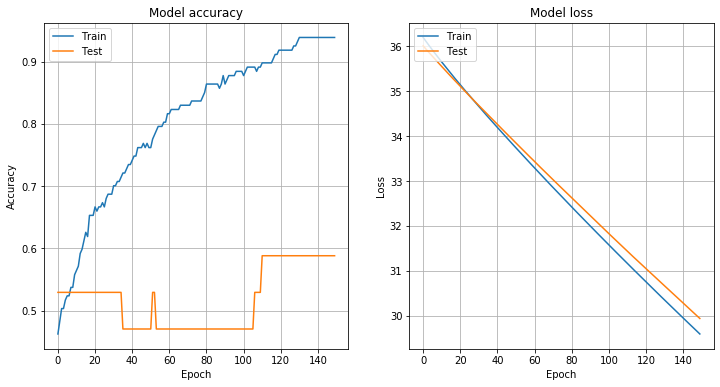

17/17 [==============================] - 0s 41us/step
Loss:29.939, Acc:0.5882


In [104]:
plot_history(history)
print("Loss:{:0.3f}, Acc:{:.4f}".format(*dnn.evaluate(X_valid,y_valid)))

In [105]:
# [x for x in dnn.predict(X_valid)]

Confusion matrix, without normalization
[[0.42857143 0.57142857]
 [0.3        0.7       ]]
Overall Accuracy: 0.5882


(<matplotlib.axes._subplots.AxesSubplot at 0x1a41ef6a58>, array([[3, 4],
        [3, 7]]))

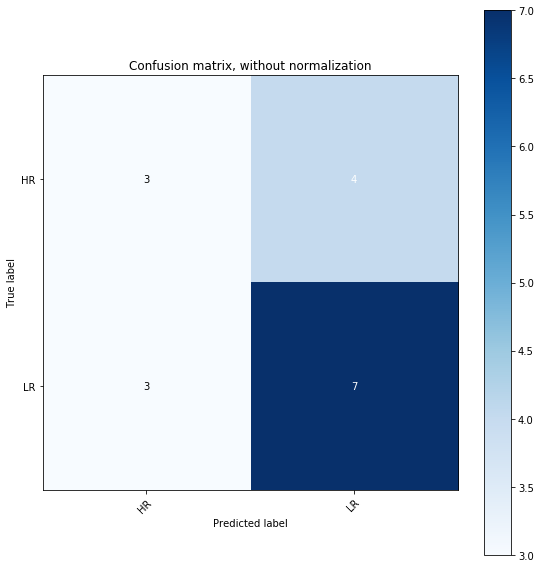

In [106]:
y_pred = np.round(np.ravel(dnn.predict(X_valid)))
plot_confusion_matrix(np.ravel(y_valid), y_pred, enc.categories_[1])

In [55]:
y_pred

array([0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.],
      dtype=float32)

In [21]:
val_samples = analysis_labels.loc[test_labels.index]
val_samples["DNN Pred"] = y_pred
val_samples[val_samples["Risk"]=="HR"]

,ASD_DX_group,Risk,DNN Pred
CandID,,,
526558,ASD,HR,0.0
950194,ASD,HR,0.0
321541,ASD,HR,0.0
857317,ASD,HR,0.0
751794,ASD,HR,1.0
677040,ATYPICAL_MULLEN,HR,1.0
402809,ASD,HR,0.0
389521,ASD,HR,0.0
456823,ASD,HR,0.0


## Calculate LRP

In [37]:
correct_HR_samples = X_valid[y_pred == np.ravel(y_valid) & (val_samples["Risk"]=="HR").values]

In [38]:
import innvestigate
import innvestigate.utils as iutils

analyzer_type = "lrp.epsilon"
analyzer_kwargs = {
    "pattern.attribution":
        {"pattern_type":"relu"},
    "lrp.epsilon":
        {"epsilon":1e-3}
 }

model_wo_softmax = dnn
# model_wo_softmax = iutils.keras.graph.model_wo_softmax(dnn)

analyzer = innvestigate.create_analyzer(analyzer_type, model_wo_softmax,
                                        **analyzer_kwargs[analyzer_type])
analyzer.fit(X_train, batch_size=20, verbose=1, disable_no_training_warning=True)

In [44]:
lrp = analyzer.analyze(correct_HR_samples)
# pd.DataFrame(relevance_results)
lrp.shape

(16, 333)

In [242]:
# TODO: Put into helper.py

def plot_3d_lrp(lrp, colors=[], labels=[]):
    
    if lrp.shape[1] > 3:

        embedding_pipeline = Pipeline([
            ("reducer", umap.UMAP(random_state=42,
                            n_components = 3,
                            n_neighbors=5,
                            min_dist=0)),
           ("scaler", MinMaxScaler())
        ])
        embedding_pipeline.fit(lrp)
        embedding = embedding_pipeline.transform(lrp)
    else:
        embedding = lrp
            

    emb3d = go.Scatter3d(
        x=embedding[:,0],
        y=embedding[:,1],
        z=embedding[:,2],
        mode="markers",
        name="Training",
        marker=dict(
            size=5,
            color=colors,
            colorscale="Rainbow",
            opacity=0.8,
            showscale=True
        ),
        text=labels
    )

    layout = go.Layout(
        title="3D LRP Embedding",
        autosize=False,
        width=1200,
        height=1000,
        paper_bgcolor='#F5F5F5',
    #     template="plotly"
    )

    data=[emb3d]

    fig = go.Figure(data=data, layout=layout)
    # fig.update_layout(template="plotly")  /

    iplot(fig, filename='lrp-3d-scatter.html')

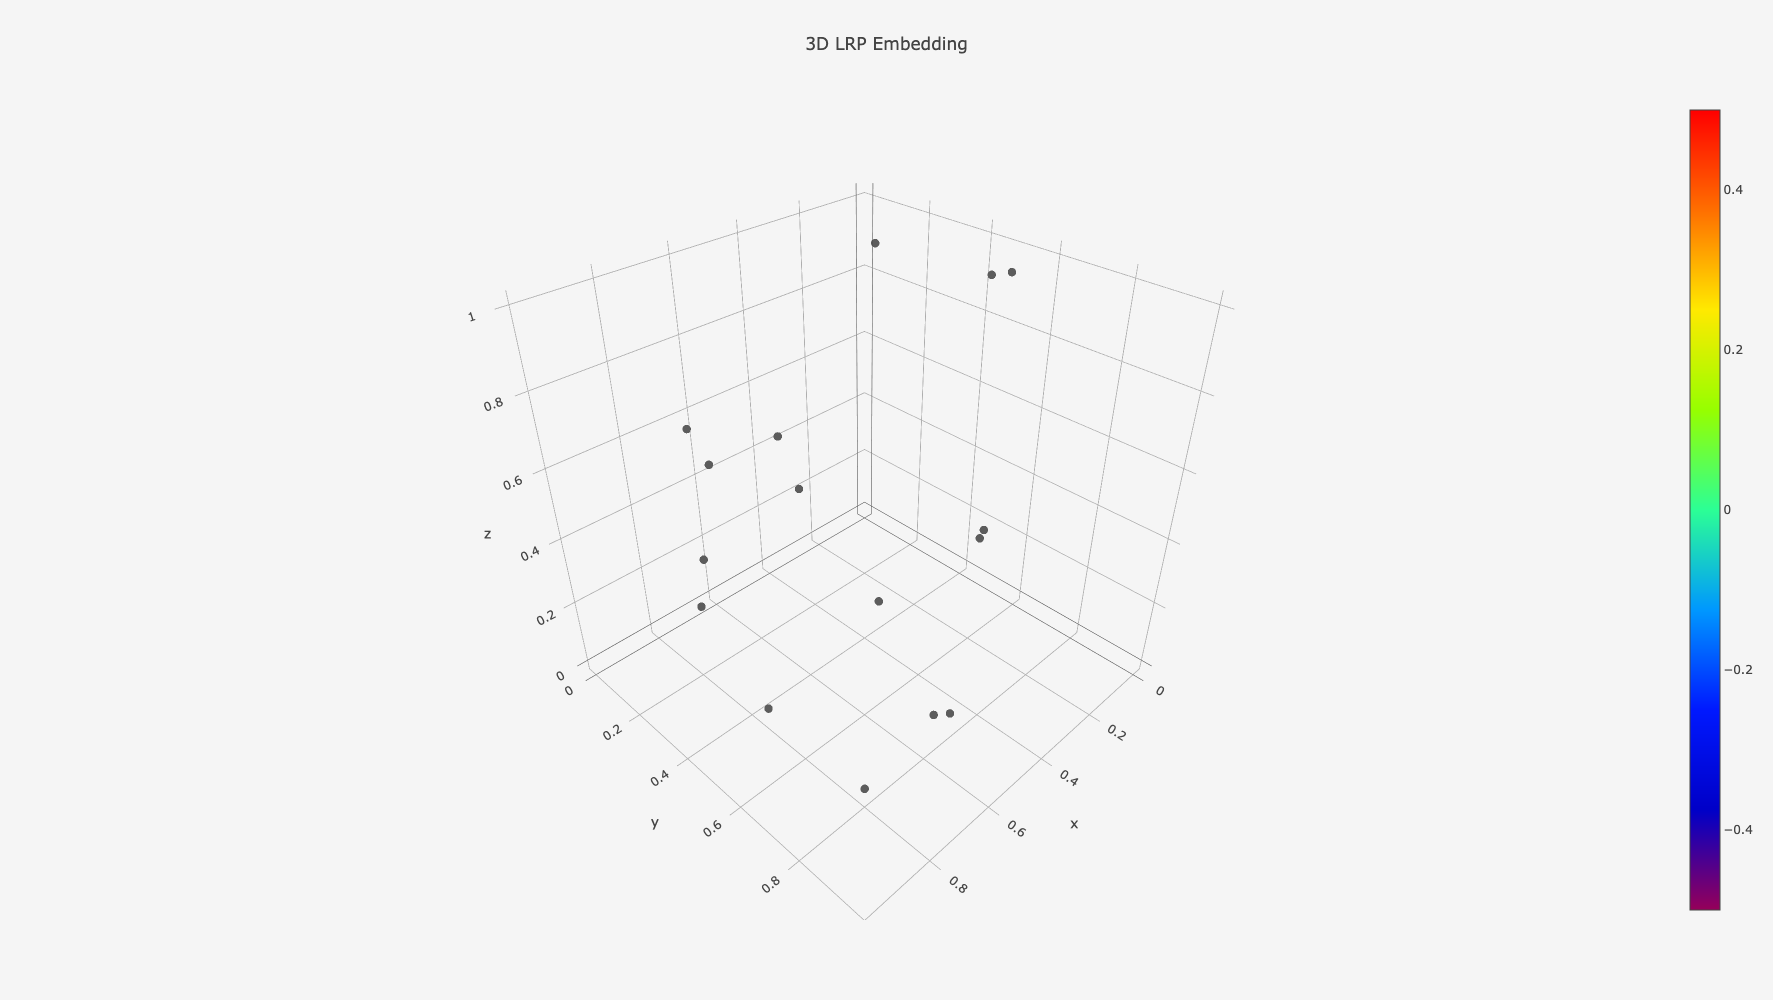

In [243]:
from sklearn.preprocessing import MinMaxScaler
reducer = umap.UMAP(random_state=42,
                    n_components = 3,
                    n_neighbors=5,
                    min_dist=0)

reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
])

reducer_pipeline.fit(lrp)
embeddings = reducer_pipeline.transform(lrp)
plot_3d_lrp(embeddings)

### Cross Validating

In [107]:
# Separating a hold out set that will be used for validation of the pipeline
train_data, train_labels, test_data, test_labels = split_valid(data, risk_labels, valid_size=0.1)

In [108]:
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=5,
                    min_dist=0)

In [109]:
dnn = build_dnn(num_features=data.shape[1], num_labels=1, activation="elu")
pipeline = ClusterPipeline(dnn, [train_data, train_labels], [test_data, test_labels],
                           target_class=0, reducer=reducer, softmax=False)

Running Serial Crossvalidation
Running worker: 0
Fold: 0 -> Loss:30.296, Acc:0.9470
Prediction Accuracy
15/15 [==============================] - 0s 2ms/step
Scores on data set: loss=31.253 accuracy=0.3333
Fold Correct: 5
Running worker: 1
Fold: 1 -> Loss:30.304, Acc:0.9470
Prediction Accuracy
15/15 [==============================] - 0s 51us/step
Scores on data set: loss=30.989 accuracy=0.6000
Fold Correct: 9
Running worker: 2
Fold: 2 -> Loss:30.312, Acc:0.9545
Prediction Accuracy
15/15 [==============================] - 0s 41us/step
Scores on data set: loss=30.788 accuracy=0.6000
Fold Correct: 9
Running worker: 3
Fold: 3 -> Loss:30.309, Acc:0.9394
Prediction Accuracy
15/15 [==============================] - 0s 39us/step
Scores on data set: loss=30.851 accuracy=0.4667
Fold Correct: 7
Running worker: 4
Fold: 4 -> Loss:30.313, Acc:0.9470
Prediction Accuracy
15/15 [==============================] - 0s 33us/step
Scores on data set: loss=30.825 accuracy=0.5333
Fold Correct: 8
Running worker:

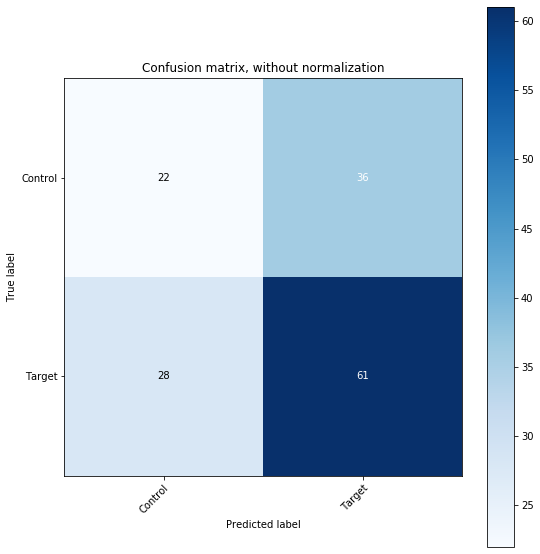

In [110]:
cm = pipeline.train_model(batch_size=20, epochs=150, cross_validation=True, parallel=False, verbose=0)

In [191]:
reindexed_labels = train_labels.iloc[pipeline.testing_idxs]
correct_idxs = pipeline.correct_preds_bool_arr
reindexed_train[correct_idxs].shape

(83,)

In [197]:
a=analysis_labels.loc[reindexed_labels[correct_idxs].index]
a[a["Risk"]=="HR"].shape

(22, 2)

In [130]:
orig_labels = analysis_labels.loc[reindexed_labels.index]
orig_labels["DNN Pred"] = pipeline.predictions
orig_HR = orig_labels[orig_labels["Risk"]=="HR"]

In [203]:
orig_HR

(36, 3)

In [212]:
_counts=[]
names=[]
for name, subgroup in orig_HR.groupby(by="ASD_DX_group"):
    names.append(name)
    _cnt = subgroup["DNN Pred"].value_counts()
    _counts.append([_cnt[0.0], _cnt[1.0]])
#     print(name, subgroup["DNN Pred"].value_counts(), sep="\n")

dnn_predictions = pd.DataFrame(_counts, columns=["Correct","Incorrect"], index=names)
dnn_predictions

,Correct,Incorrect
ASD,15,18
ATYPICAL_ADOS,5,12
ATYPICAL_MULLEN,2,6


In [213]:
norm_pred = dnn_predictions.div(dnn_predictions.sum(axis=1), axis="index")

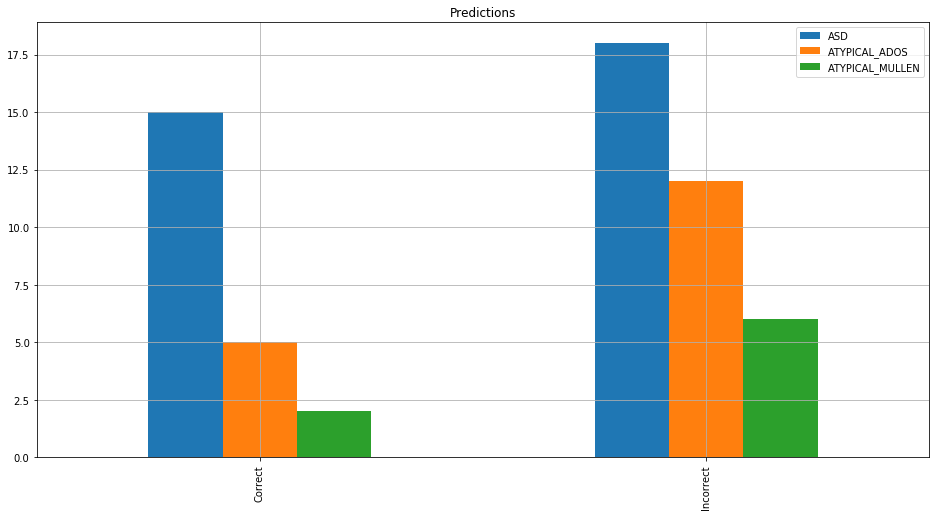

In [215]:
dnn_predictions.T.plot(kind="bar", figsize=(16,8), grid=True, title="Predictions")

In [233]:
from sklearn.preprocessing import MinMaxScaler
reducer = umap.UMAP(random_state=42,
                    n_components = 10,
                    n_neighbors=5,
                    min_dist=0)

pipeline.reducer_pipeline = Pipeline([
            ("umap", reducer),
            ("scaler",  MinMaxScaler())
        ])

_, correct_pred_idxs = pipeline.train_clusterer(plot=False, class_label = 0)
print("Clusters Found:", max(pipeline.clusterer.labels_)+1)

LRP Shape:  (22, 333)
Cluster Search Space: range(2, 8)
Minimum Size:
Clusters                  (5, 5)
Noise                     (2, 2)
Halkidi                   (2, 2)
Halkidi-Filtered Noise    (2, 2)
dtype: object
Clusters Found: 3


In [235]:
_correct=analysis_labels.loc[reindexed_labels[correct_idxs].index]
correct_HR = _correct[_correct["Risk"]=="HR"]

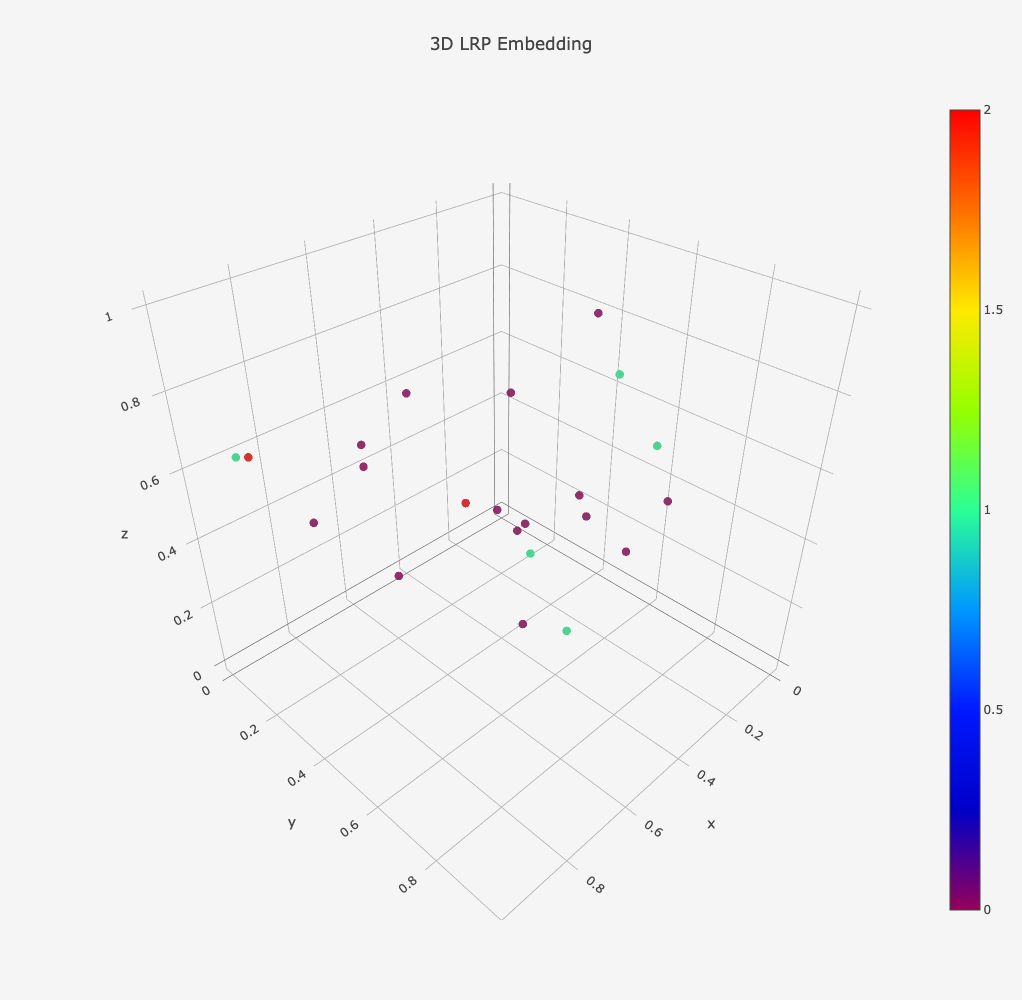

In [241]:
plot_3d_lrp(pipeline.training_lrp, colors=enc.transform(correct_HR)[:,0], labels=correct_HR["ASD_DX_group"])